In [1]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    zero_one_loss, 
    accuracy_score, 
    f1_score,
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report
)

import warnings
warnings.filterwarnings('ignore')
sb.set()

In [2]:
data= pd.read_csv('cardio_train.csv', delimiter=';')
data
#show data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [3]:
data.info()
#show data types and variable names

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [4]:
print(data.shape)
print(data.dtypes)
#show shape and data types

(70000, 13)
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object


divide age by 365 to get age in years (previously data of age was in days) 

if statement is to protect the data from being divided too many times if we keep running it

In [5]:
if data['age'].iat[0] > 100:
    data['age'] = data['age'].div(365).round(0).astype('int')

data['age']


0        50
1        55
2        52
3        48
4        48
         ..
69995    53
69996    62
69997    52
69998    61
69999    56
Name: age, Length: 70000, dtype: int32

There is data that is clearly too extreme (e.g highest ap_hi is 16020)

Have to make a copy of the original encoded data for machine learning purposes.

In [6]:


learndata = data.copy(deep = True)

data.describe()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


"Systolic pressure below 90 mmHg is considered low and may require intervention and management from your healthcare provider. If you get multiple systolic pressure readings above 180 mmHg, it is considered dangerously high"

With that information, we need to drop the data which are too extreme (lower than 70 and higher than 200.)

In [7]:
#show % of data beyond normal range

bad_aphi = (data.ap_hi < 70) | (data.ap_hi > 200)
data[bad_aphi].ap_hi.count() / data.ap_hi.count()



0.0041285714285714285

% is very low so it is safe to remove without affecting data significantly

In [8]:
# drop bad data
data.drop(data[bad_aphi].index, inplace = True)

"Normal diastolic blood pressure during quiet rest is below 80 mmHg.1 If you have high blood pressure, the diastolic number is often higher even during quiet rest. Diastolic blood pressure is considered dangerously low when it is 60 mmHg or lower and dangerously high when it is 110 mmHg or over."

Hence we remove extremes

In [9]:

#show % of data beyond normal range

bad_aplo = (data.ap_lo < 40) | (data.ap_lo > 130) 
data[bad_aplo].ap_lo.count() / data.ap_lo.count()

# % is very low so it is safe to remove without affecting data significantly

0.014947425800806186

In [10]:
# drop bad data
data.drop(data[bad_aplo].index, inplace = True)

data[bad_aplo].ap_lo.count() / data.ap_lo.count()

0.0

In [11]:
learndata.drop(learndata[(learndata.ap_hi < 70) | (learndata.ap_hi > 200)].index, inplace = True)
learndata.drop(learndata[(learndata.ap_lo < 40) | (learndata.ap_lo > 130)].index, inplace = True)

#drop from encoded data

In [12]:
learndata.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68669.000000,68669.000000,68669.000000,68669.000000,68669.000000,68669.000000,68669.00000,68669.000000,68669.000000,68669.000000,68669.000000,68669.000000,68669.000000
mean,49972.802385,53.324615,1.348556,164.359143,74.107421,126.548195,81.30047,1.364298,1.225589,0.087973,0.053488,0.803317,0.494372
std,28846.378198,6.768885,0.476517,8.184371,14.320946,16.531229,9.40953,0.678699,0.571533,0.283257,0.225007,0.397493,0.499972
min,0.000000,30.000000,1.000000,55.000000,11.000000,70.000000,40.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25000.000000,48.000000,1.000000,159.000000,65.000000,120.000000,80.00000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50007.000000,54.000000,1.000000,165.000000,72.000000,120.000000,80.00000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74870.000000,58.000000,2.000000,170.000000,82.000000,140.000000,90.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,65.000000,2.000000,250.000000,200.000000,200.000000,130.00000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


# Exploratory Data


In [13]:
NumData = pd.DataFrame(data[['age','height','weight','ap_hi','ap_lo']])
NumData.head()

,age,height,weight,ap_hi,ap_lo
0,50,168,62.0,110,80
1,55,156,85.0,140,90
2,52,165,64.0,130,70
3,48,169,82.0,150,100
4,48,156,56.0,100,60


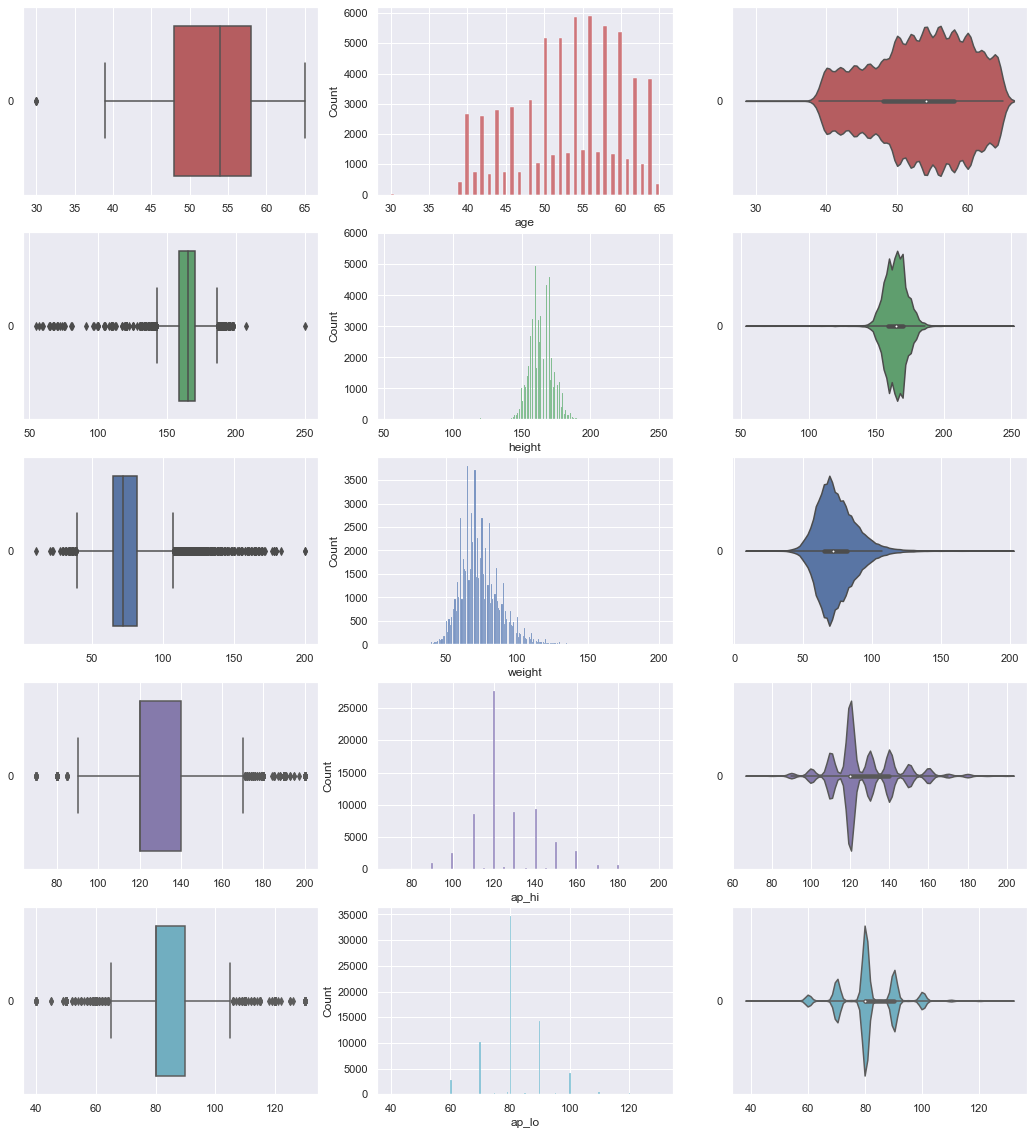

In [14]:
f, axes = plt.subplots(5, 3, figsize=(18, 20))
colors = ["r", "g", "b","m","c"]

count = 0
for var in NumData:
    sb.boxplot(data=NumData[var], orient = "h", color = colors[count], ax = axes[count,0])
    sb.histplot(data=NumData[var], color = colors[count], ax = axes[count,1])
    sb.violinplot(data=NumData[var], orient = "h", color = colors[count], ax = axes[count,2])
    count += 1
    


             age    height    weight     ap_hi     ap_lo
age     1.000000 -0.081486  0.054261  0.210359  0.155273
height -0.081486  1.000000  0.291904  0.017070  0.035442
weight  0.054261  0.291904  1.000000  0.269491  0.251700
ap_hi   0.210359  0.017070  0.269491  1.000000  0.712870
ap_lo   0.155273  0.035442  0.251700  0.712870  1.000000


<AxesSubplot:>

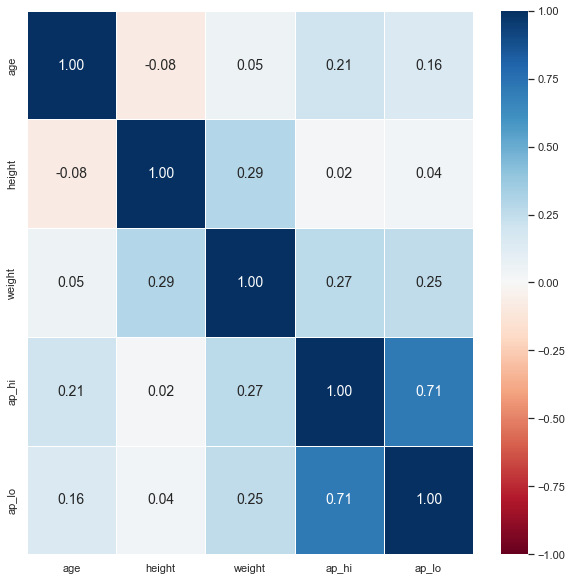

In [15]:
 #Correlation Matrix
print(NumData.corr())

# Heatmap of the Correlation Matrix
f, axes = plt.subplots(1, 1, figsize=(10, 10))
sb.heatmap(NumData.corr(), vmin = -1, vmax = 1,  linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 14}, cmap = "RdBu")

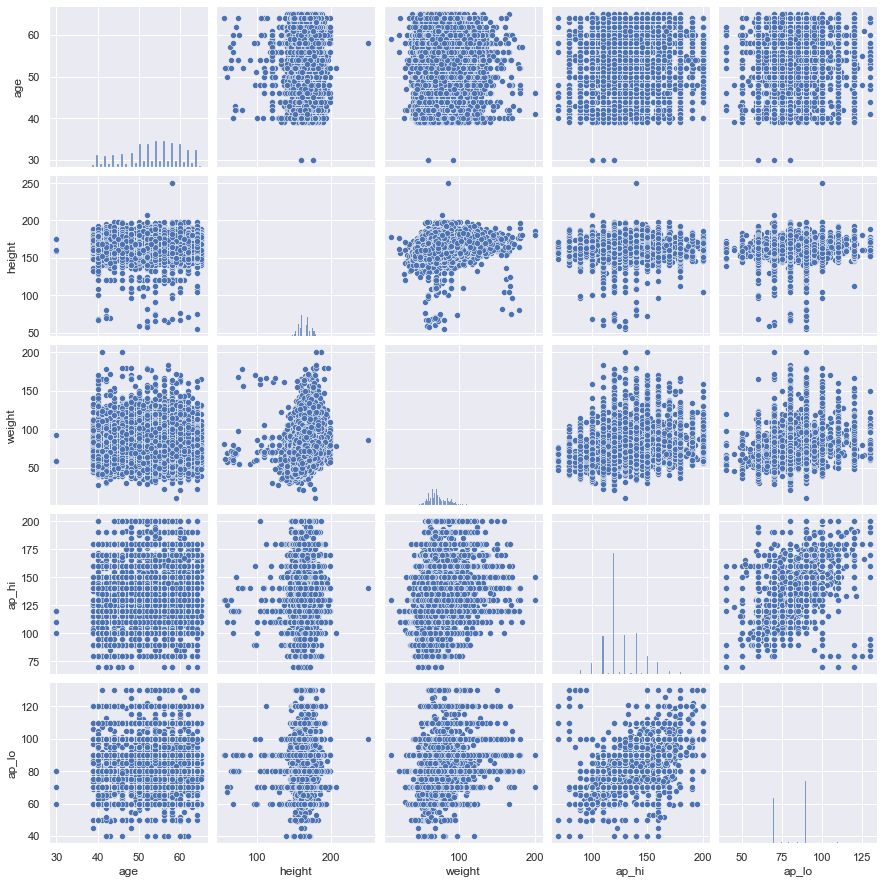

In [16]:
sb.pairplot(data = NumData)

There is a strong linear relationship between ap_hi and ap_lo

we change the data types of some data with proper headings in order to visualise the relationships easier

In [17]:
for var in data[["gender","cholesterol","gluc","smoke","alco","active","cardio"]]:
    data[var] = data[var].astype('category')

print(data.dtypes)

id                int64
age               int32
gender         category
height            int64
weight          float64
ap_hi             int64
ap_lo             int64
cholesterol    category
gluc           category
smoke          category
alco           category
active         category
cardio         category
dtype: object


In [18]:

data['gender'] = data["gender"].replace([1,2],["female","male"])
data['cholesterol'] = data["cholesterol"].replace([1,2,3],["normal","above normal","well above normal"])
data['gluc'] = data["gluc"].replace([1,2,3],["normal","above normal","well above normal"])
data['smoke'] = data["smoke"].replace([1,0],["True","False"])
data['alco'] = data["alco"].replace([1,0],["Yes","No"])
data['active'] = data["active"].replace([1,0],["Yes","No"])
data['cardio'] = data["cardio"].replace([1,0],["Yes","No"])
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,male,168,62.0,110,80,normal,normal,False,No,Yes,No
1,1,55,female,156,85.0,140,90,well above normal,normal,False,No,Yes,Yes
2,2,52,female,165,64.0,130,70,well above normal,normal,False,No,No,Yes
3,3,48,male,169,82.0,150,100,normal,normal,False,No,Yes,Yes
4,4,48,female,156,56.0,100,60,normal,normal,False,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,male,168,76.0,120,80,normal,normal,True,No,Yes,No
69996,99995,62,female,158,126.0,140,90,above normal,above normal,False,No,Yes,Yes
69997,99996,52,male,183,105.0,180,90,well above normal,normal,False,Yes,No,Yes
69998,99998,61,female,163,72.0,135,80,normal,above normal,False,No,No,Yes


In [19]:
#Extract the required variables from the dataset, as mentioned in the problem.

CatData = pd.DataFrame(data[['gender','cholesterol','gluc','smoke','alco','active','cardio']])
CatData.head()

,gender,cholesterol,gluc,smoke,alco,active,cardio
0,male,normal,normal,False,No,Yes,No
1,female,well above normal,normal,False,No,Yes,Yes
2,female,well above normal,normal,False,No,No,Yes
3,male,normal,normal,False,No,Yes,Yes
4,female,normal,normal,False,No,No,No


In [20]:

    CatData.info()
    NumData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68669 entries, 0 to 69999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   gender       68669 non-null  category
 1   cholesterol  68669 non-null  category
 2   gluc         68669 non-null  category
 3   smoke        68669 non-null  category
 4   alco         68669 non-null  category
 5   active       68669 non-null  category
 6   cardio       68669 non-null  category
dtypes: category(7)
memory usage: 3.0 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 68669 entries, 0 to 69999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     68669 non-null  int32  
 1   height  68669 non-null  int64  
 2   weight  68669 non-null  float64
 3   ap_hi   68669 non-null  int64  
 4   ap_lo   68669 non-null  int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 4.9 MB


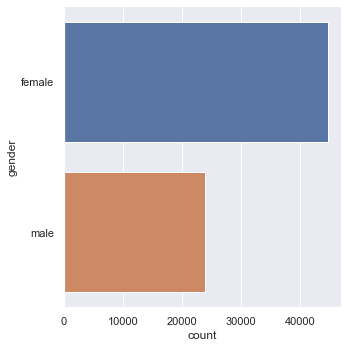

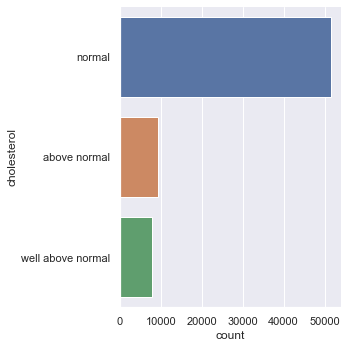

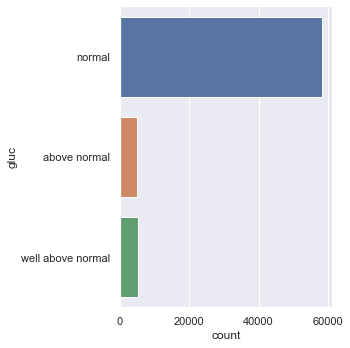

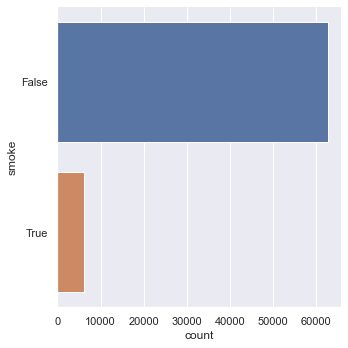

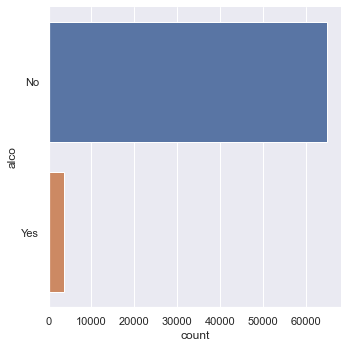

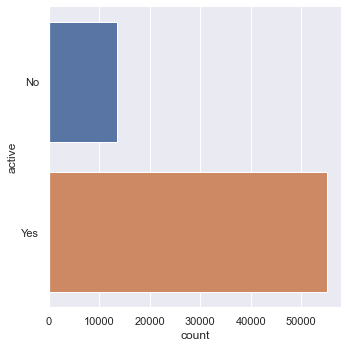

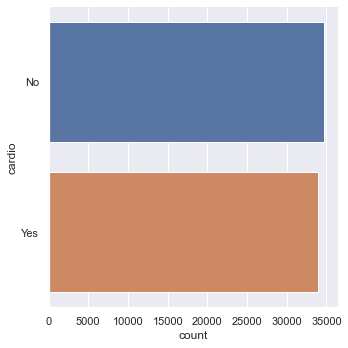

In [21]:
for var in CatData:
    sb.catplot(y = var, data = CatData, kind = "count", height = 5)



no striking anomalies in our data set other than the disproportionate amount of females to males (roughly 2:1).

 count of those who have cardiovascular disease and those who dont are roughly 50-50%, thus this dataset is suitable for machine learning

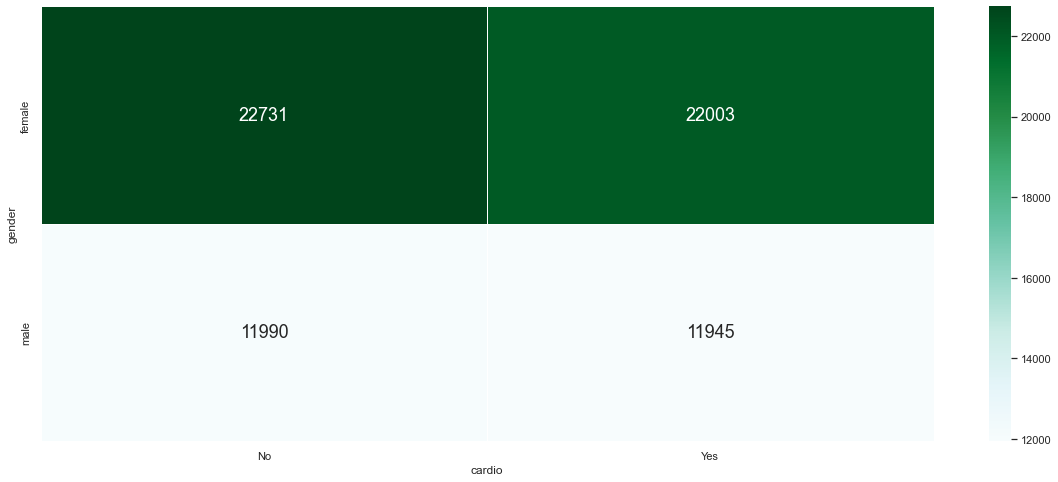

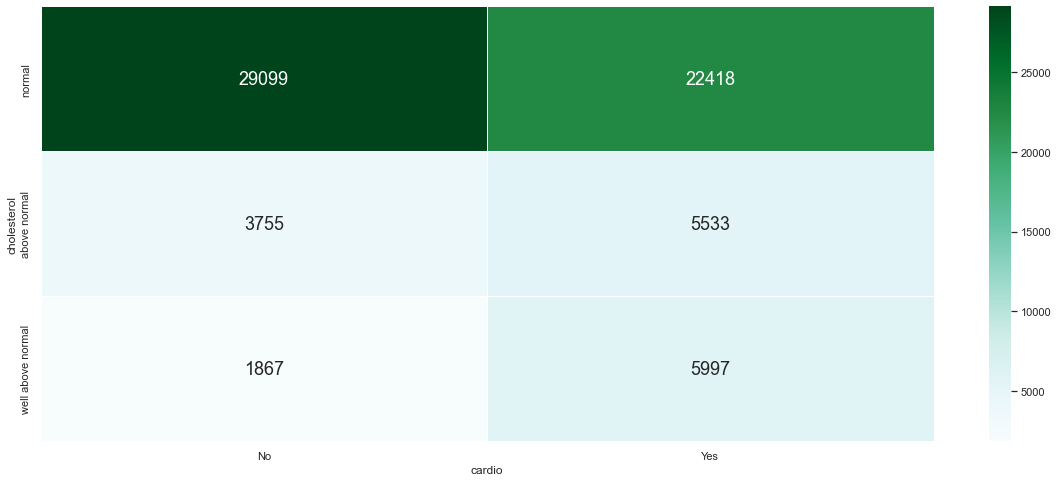

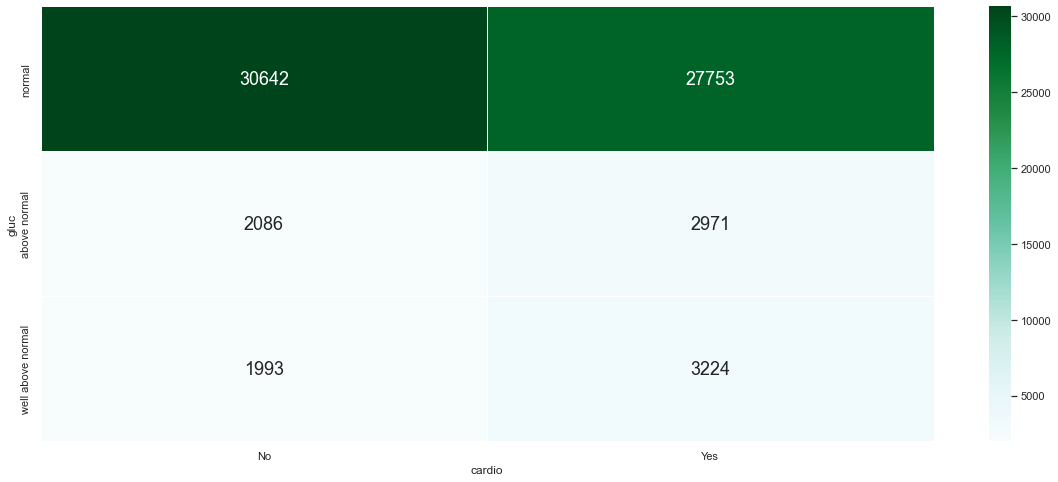

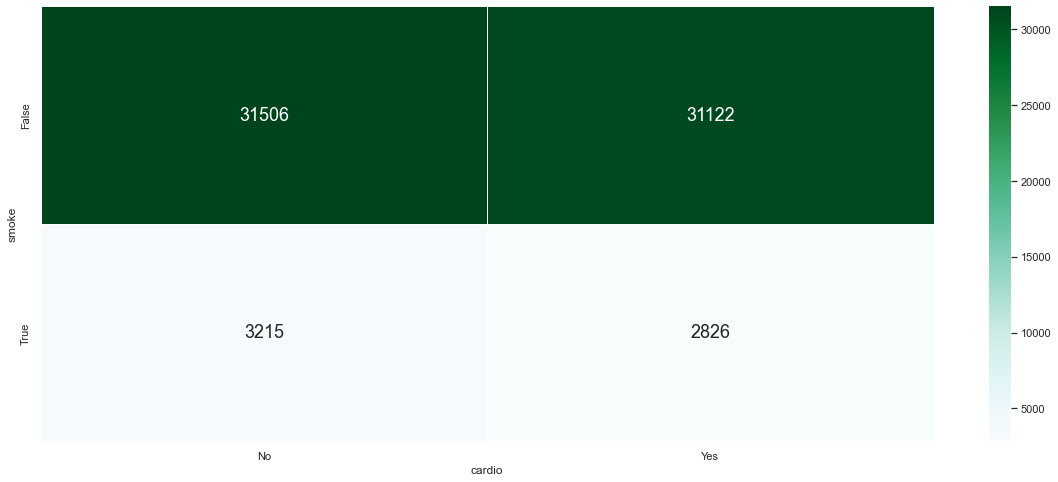

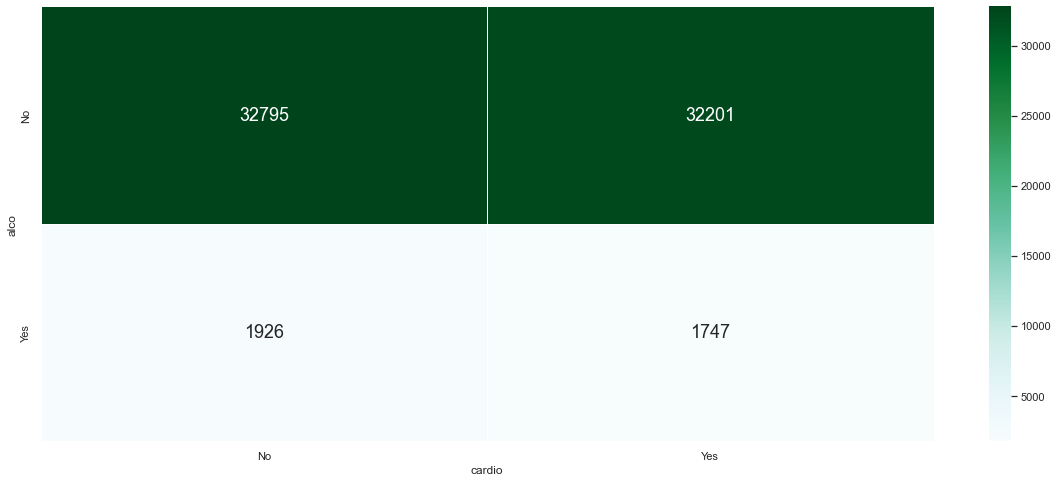

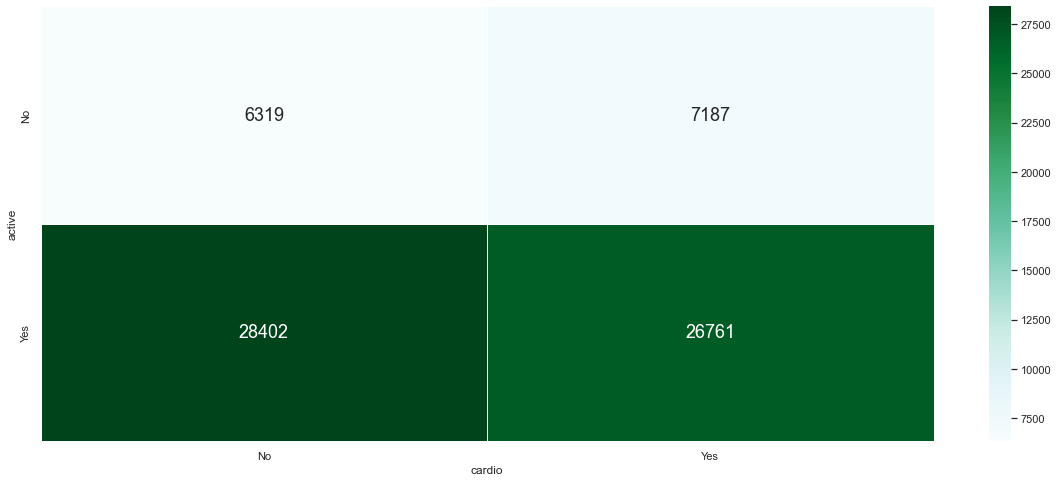

In [22]:
for var in CatData[['gender','cholesterol','gluc','smoke','alco','active']]:
    f, axes = plt.subplots(1, 1, figsize=(20, 8))
    sb.heatmap(CatData.groupby([var, 'cardio']).size().unstack(), 
             linewidths = 1, annot = True, fmt = 'g', annot_kws = {"size": 18}, cmap = "BuGn")

The only factor among our categorical data that appears to be clearly related to heart disease is the cholesterol level.

Blood glucose level appears to be slightly related to the presence of cardiovascular disease.

Surprisingly, smoking and alcohol does not appear to be related to cardiovascular disease in our data set, however, the sample size of smokers and people who consume alcohol is very small, thus more information is needed.

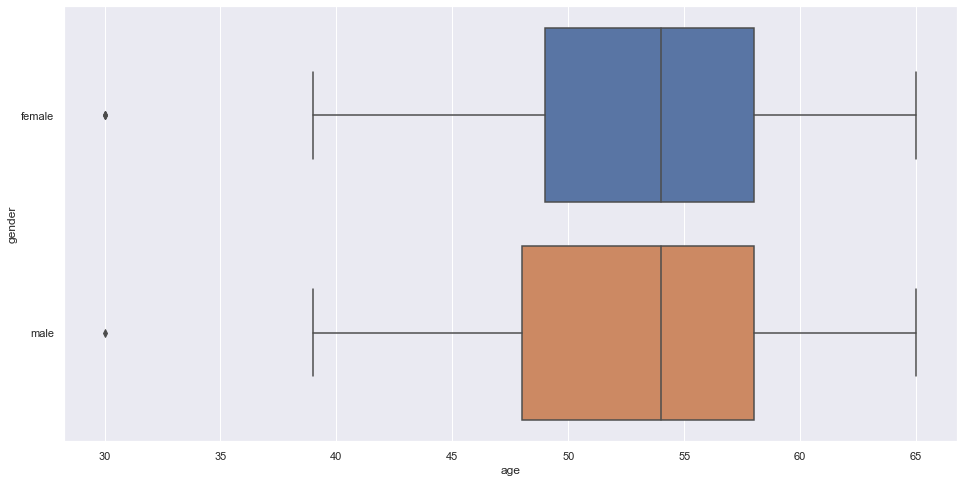

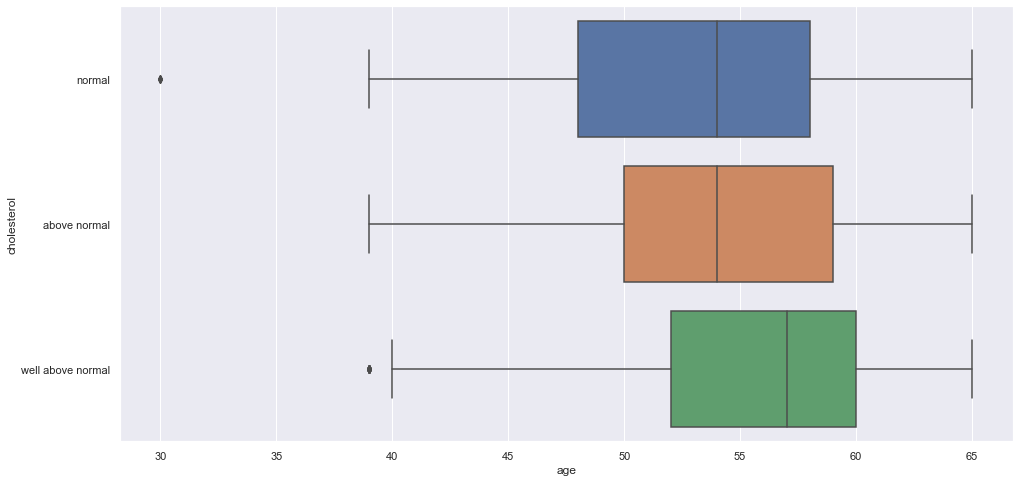

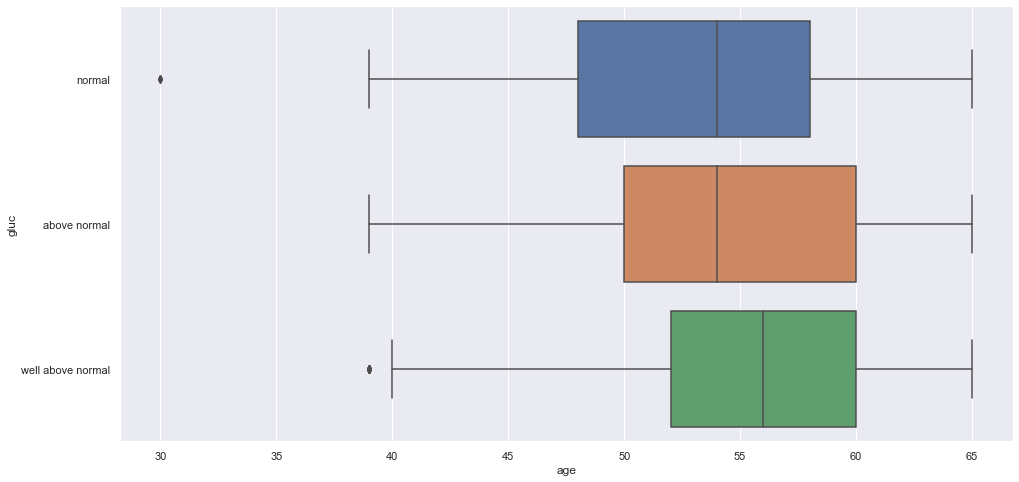

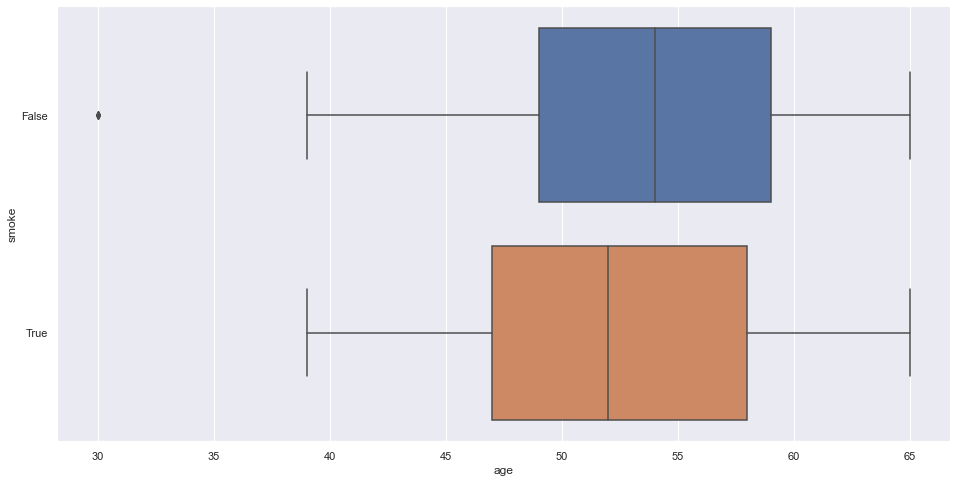

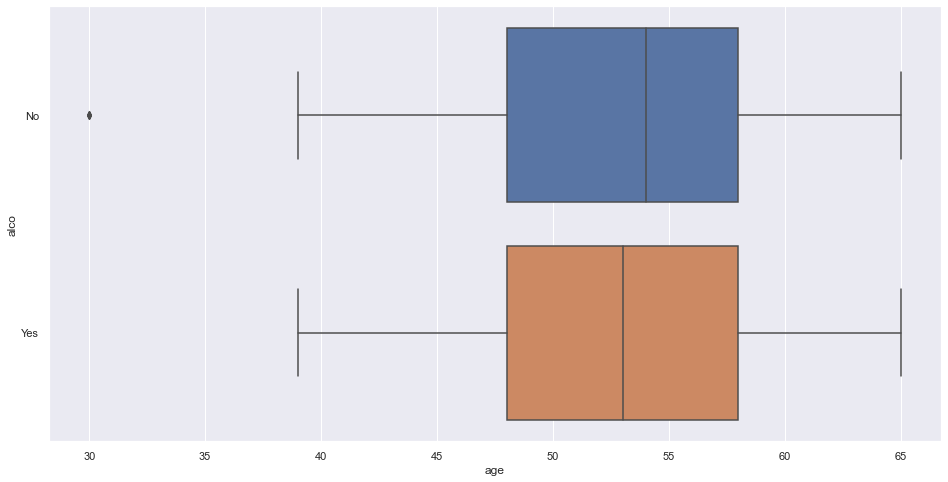

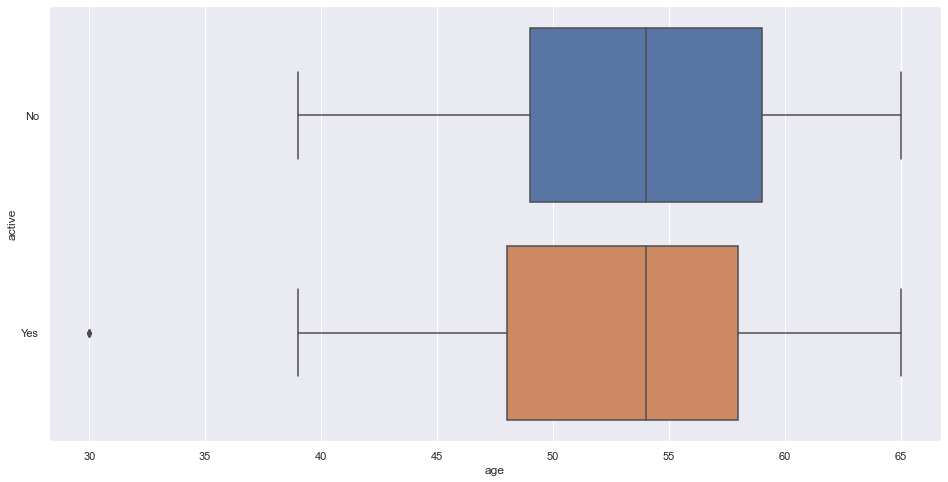

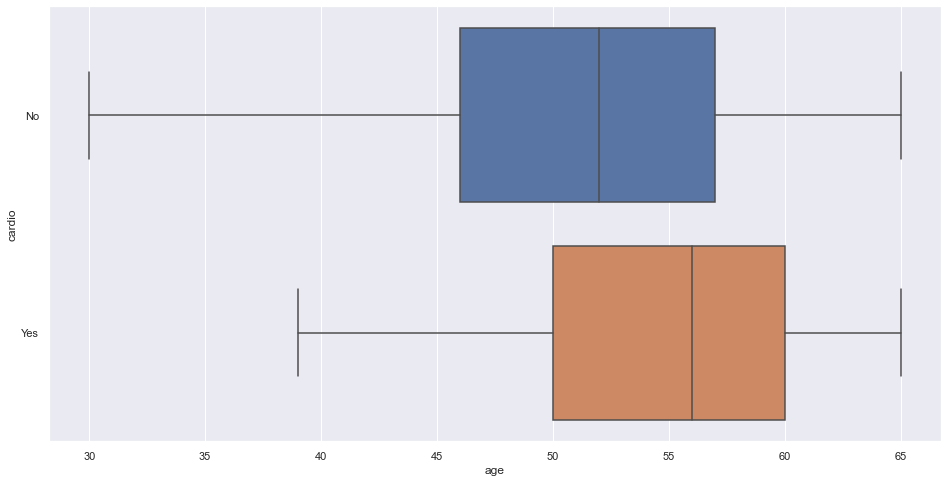

In [23]:
for var in CatData:
    f, axes = plt.subplots(1, 1, figsize=(16, 8))
    sb.boxplot(x = 'age', y = CatData[var], data = data)

cholesterol and blood sugar levels appear to be higher on average the older the person is

Those affected by heart disease also tend to be on the older side.

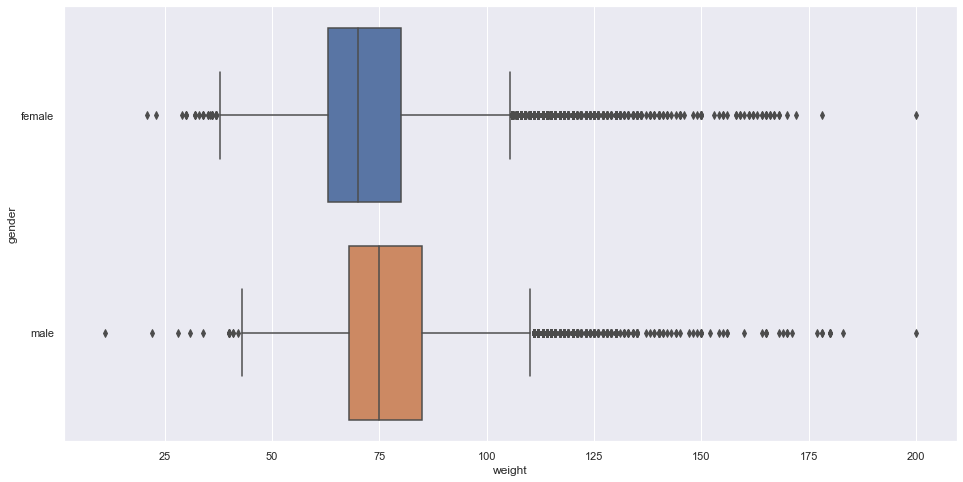

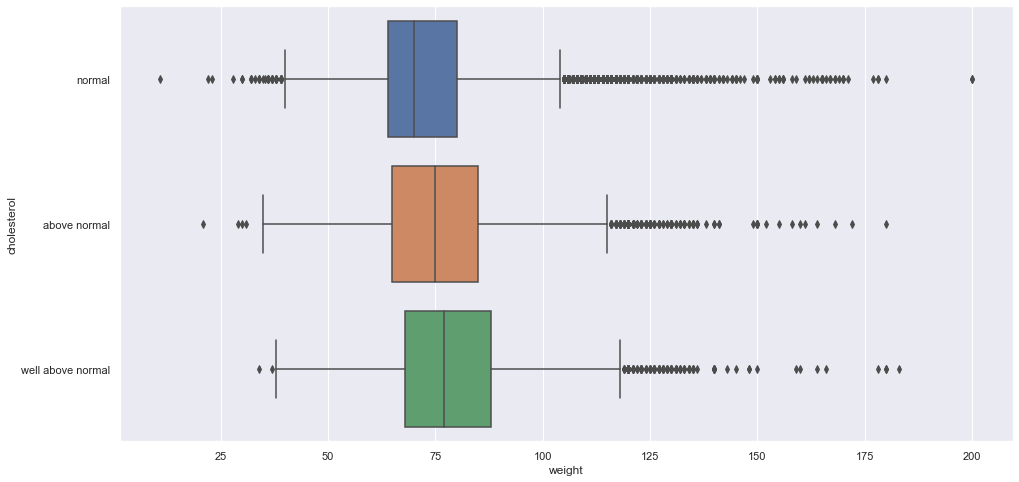

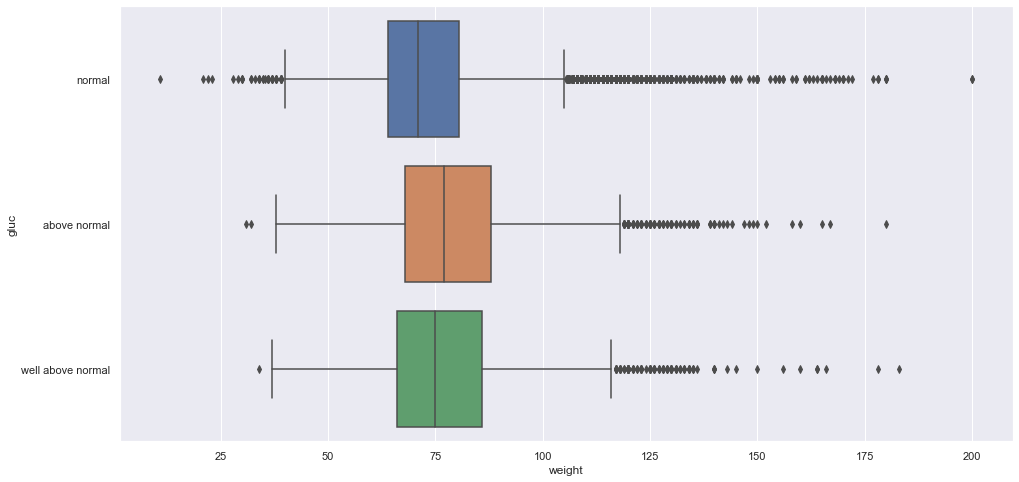

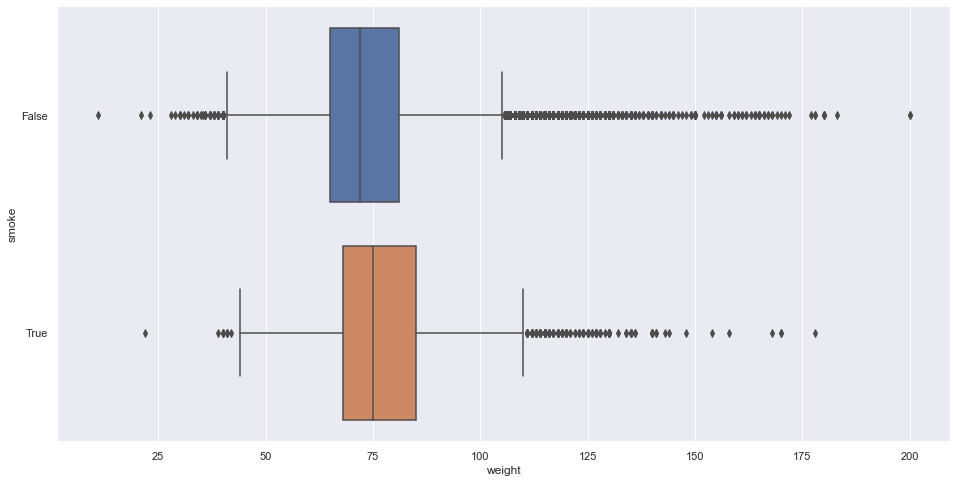

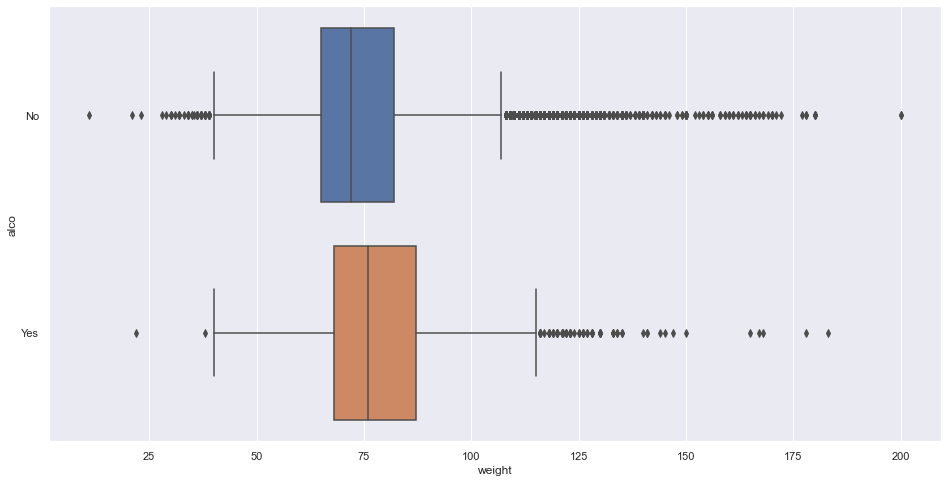

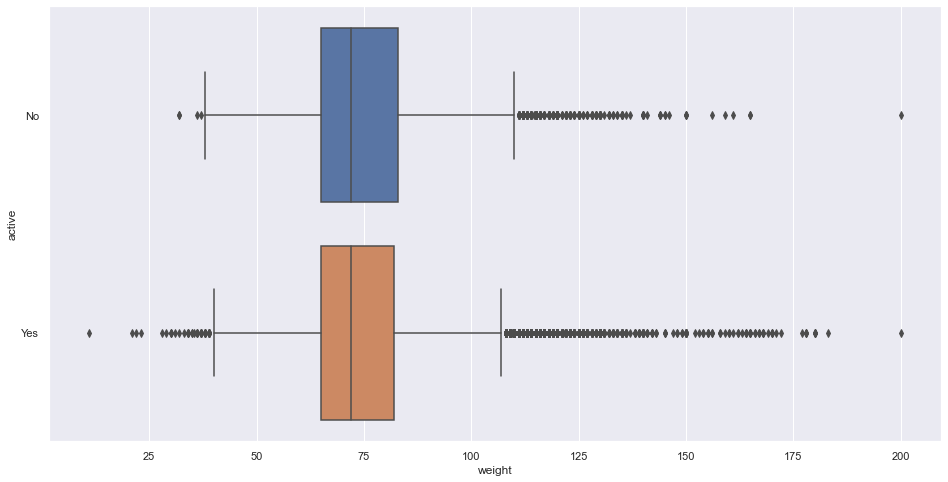

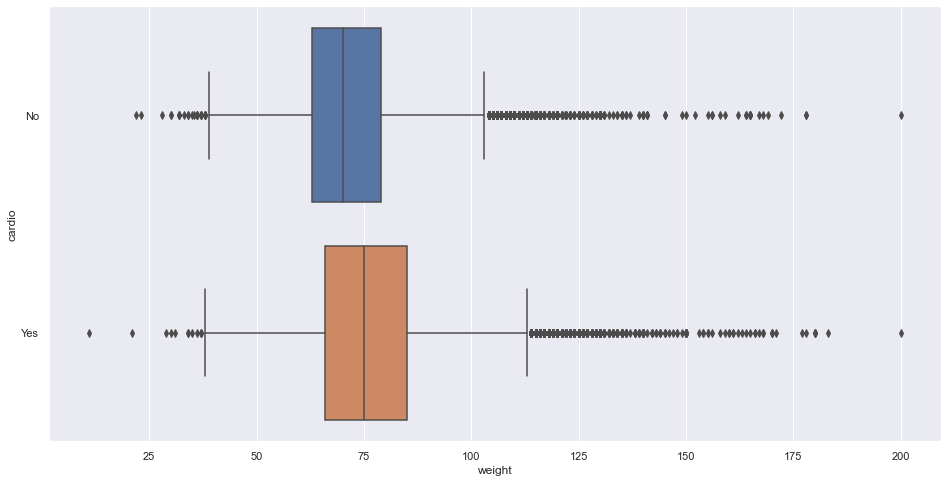

In [24]:
for var in CatData:
    f, axes = plt.subplots(1, 1, figsize=(16, 8))
    sb.boxplot(x = 'weight', y = CatData[var], data = data)

People who engage in smoking and alcohol consumption tend to have higher weight, those who are affected by cardiovascular disease also tend to be heavier on average. This may be a relationship that was previously unexplored by just the counts in the previous section.

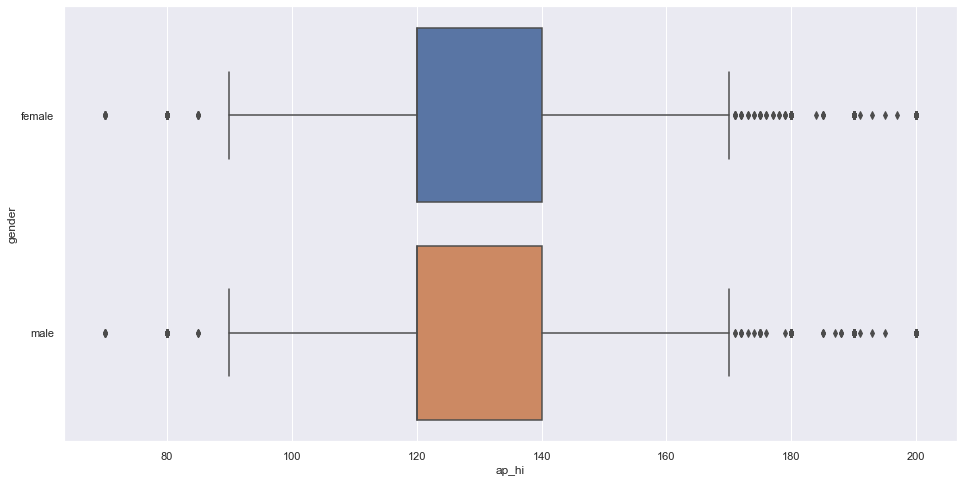

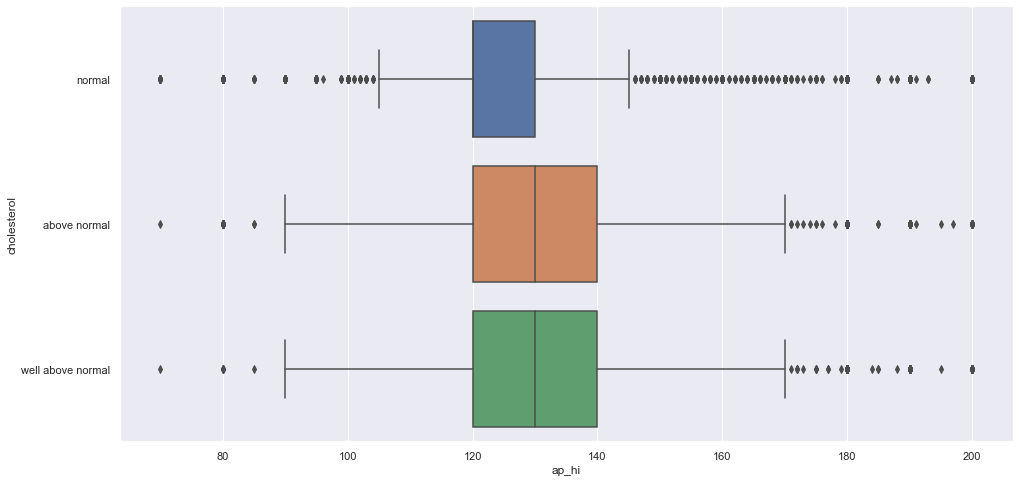

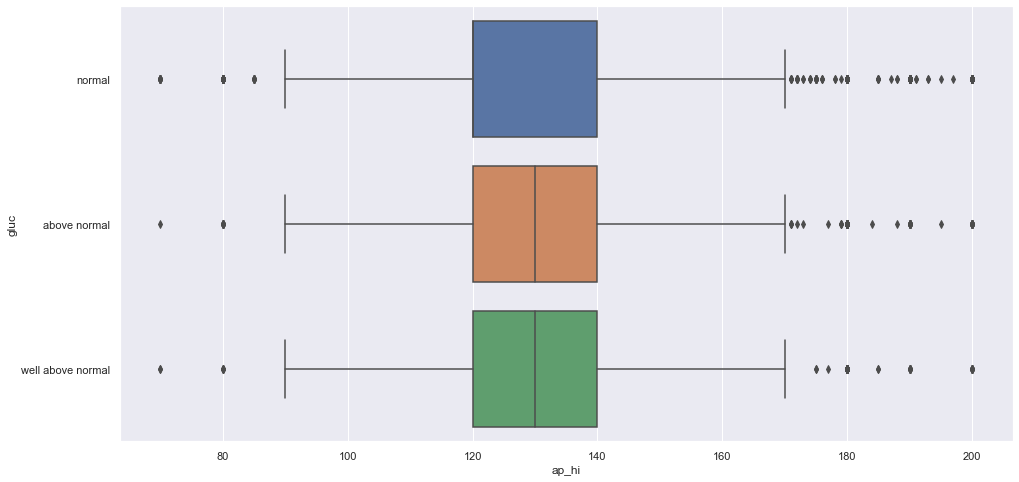

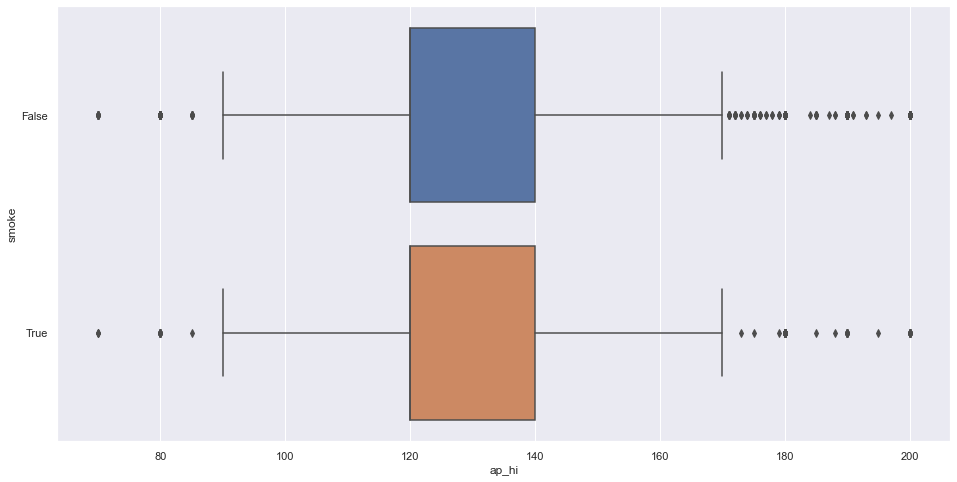

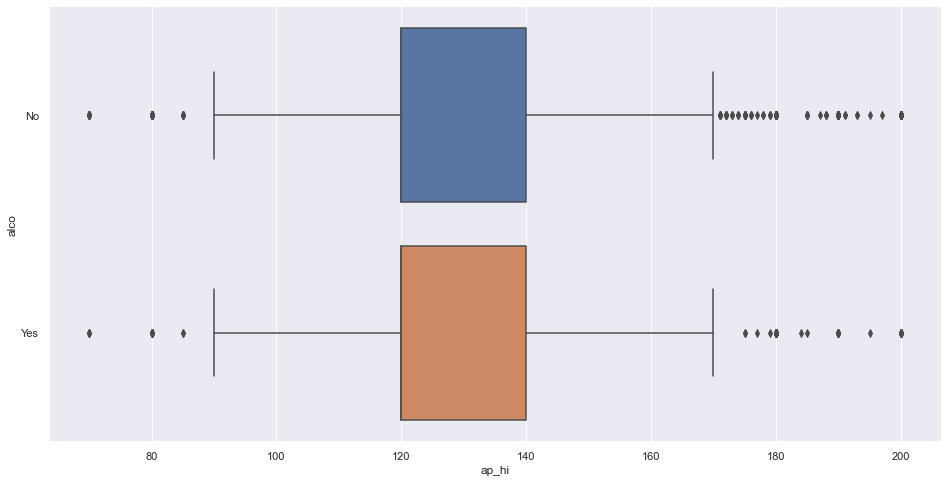

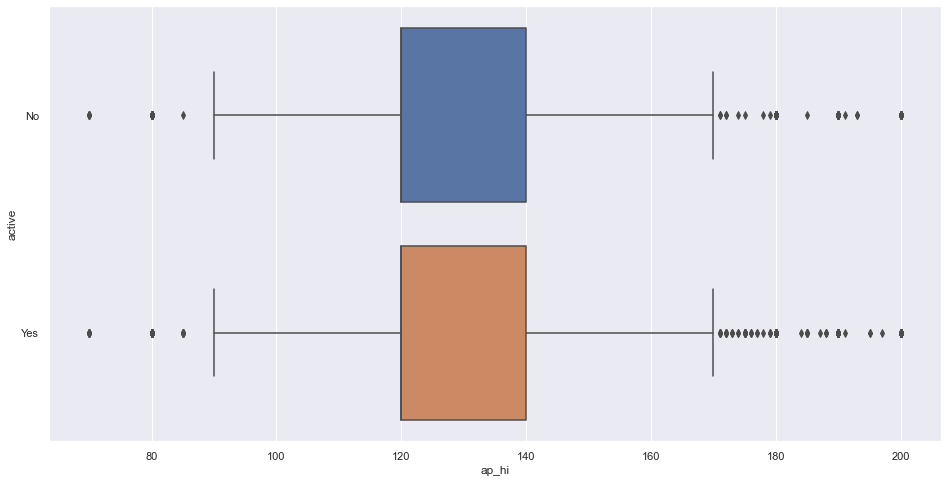

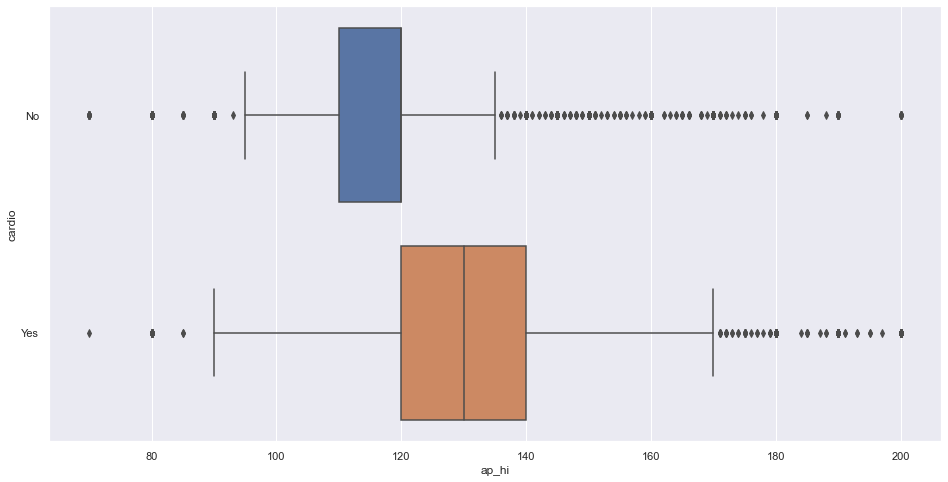

In [25]:
for var in CatData:
    f, axes = plt.subplots(1, 1, figsize=(16, 8))
    sb.boxplot(x = 'ap_hi', y = CatData[var], data = data)

those with higher cholesterol levels tend to exhibit more extreme ap_hi values,

a higher ap_hi seems to correlate to the presence of cardiovascular disease


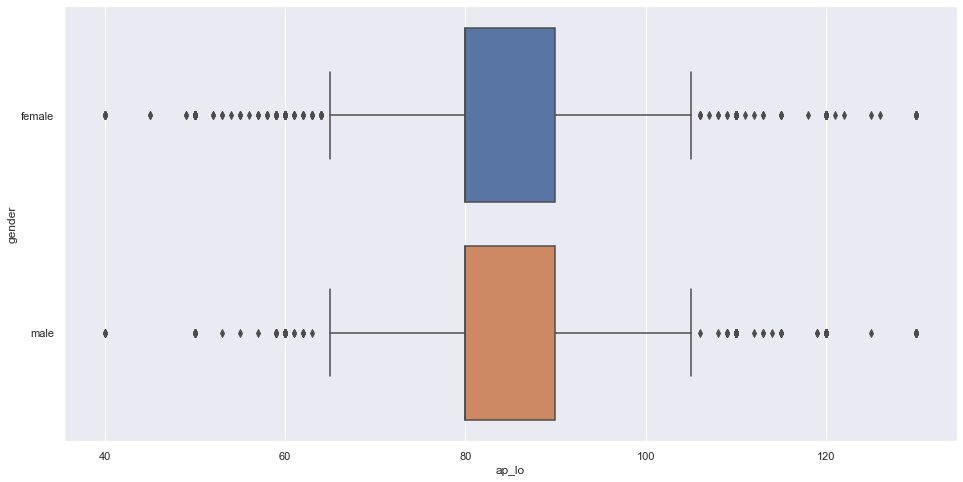

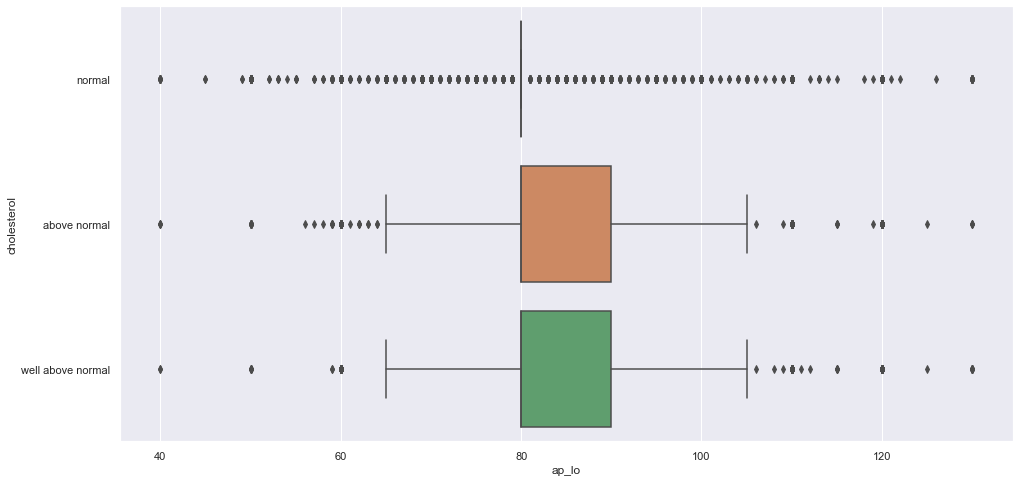

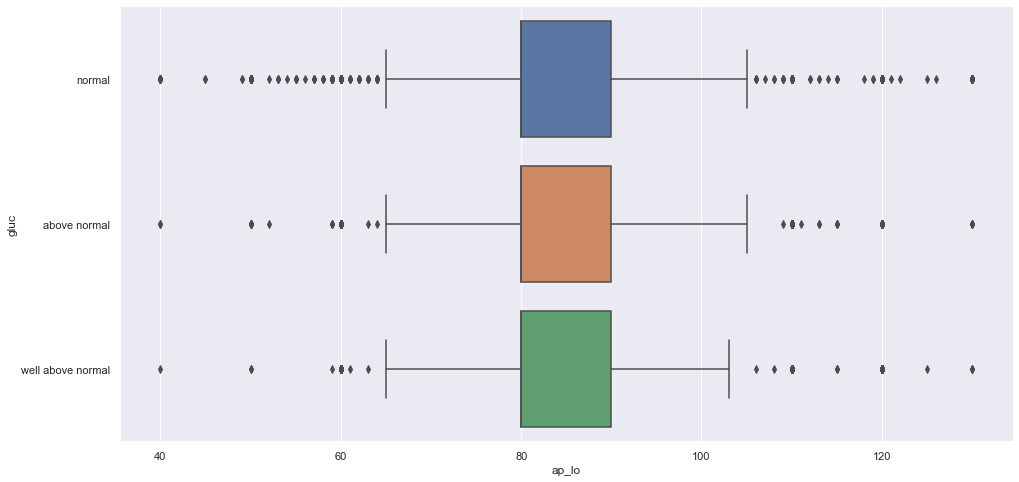

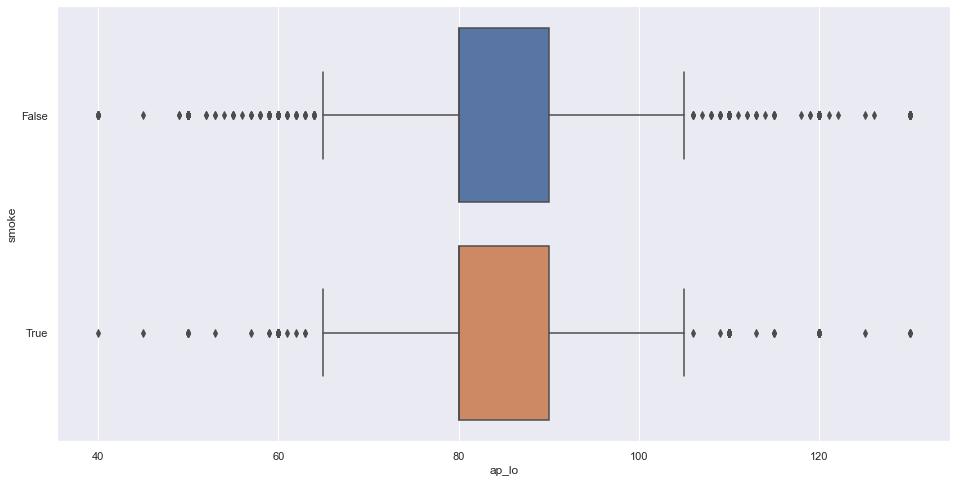

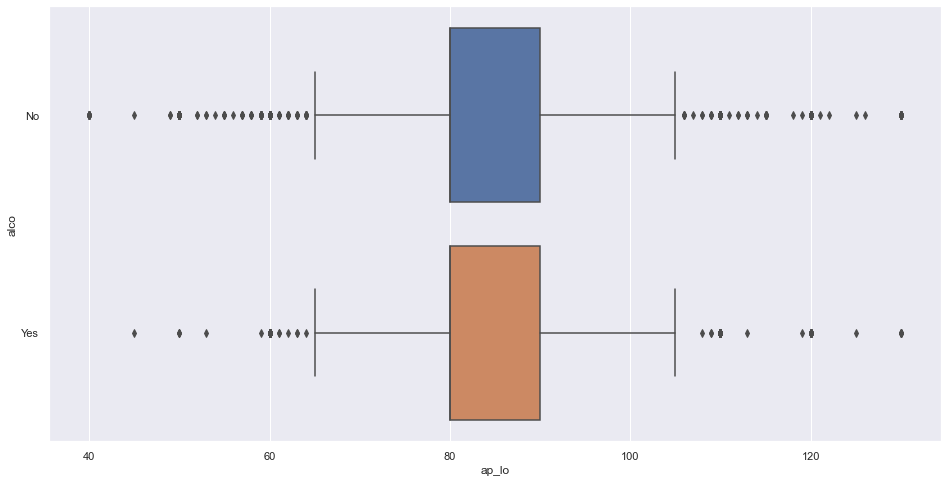

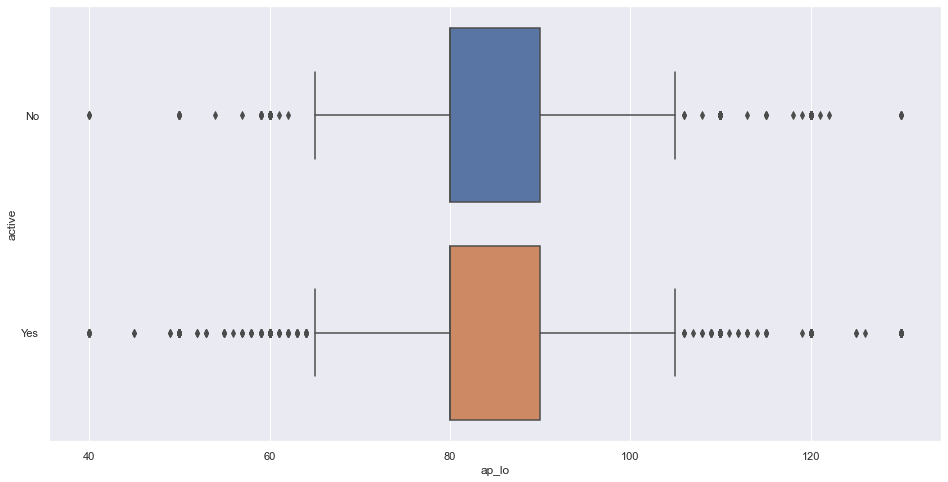

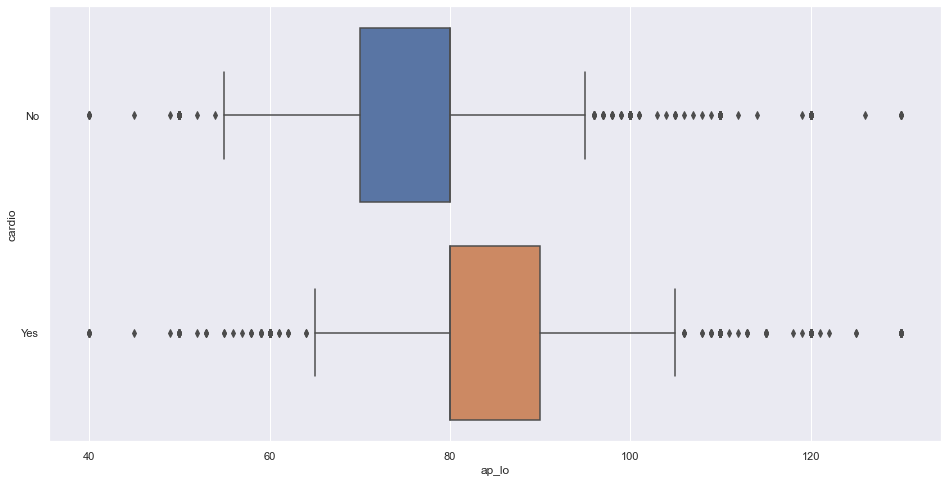

In [26]:
for var in CatData:
    f, axes = plt.subplots(1, 1, figsize=(16, 8))
    sb.boxplot(x = 'ap_lo', y = CatData[var], data = data)

similarly, those with high cholesterol tend to exhibit more extreme ap_lo values, and people with cardiovascular disease tend to have higher ap_lo values.

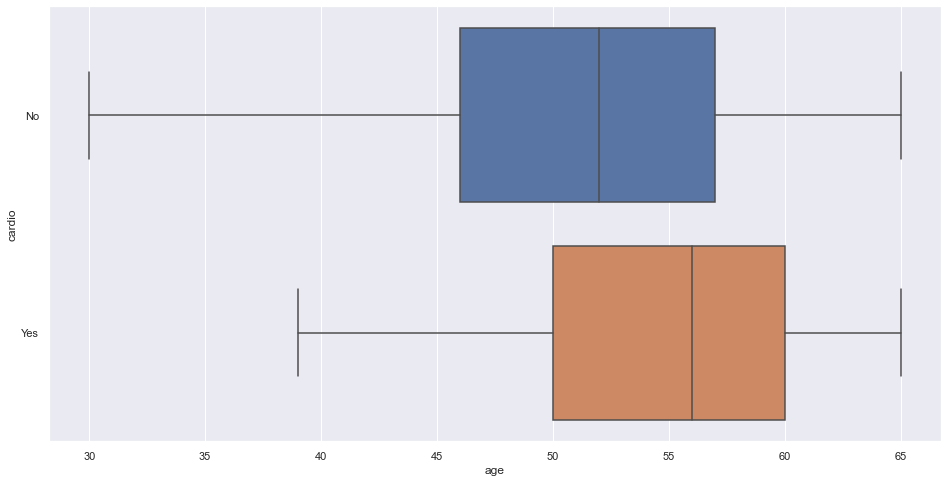

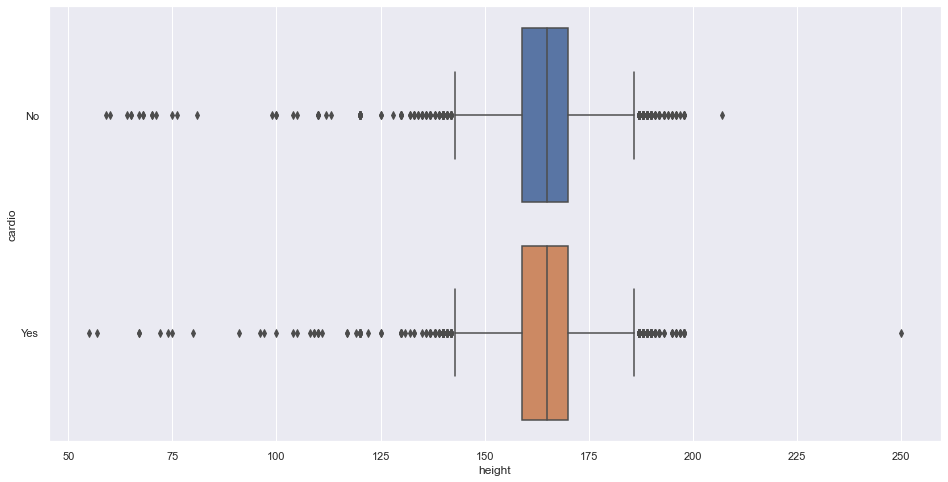

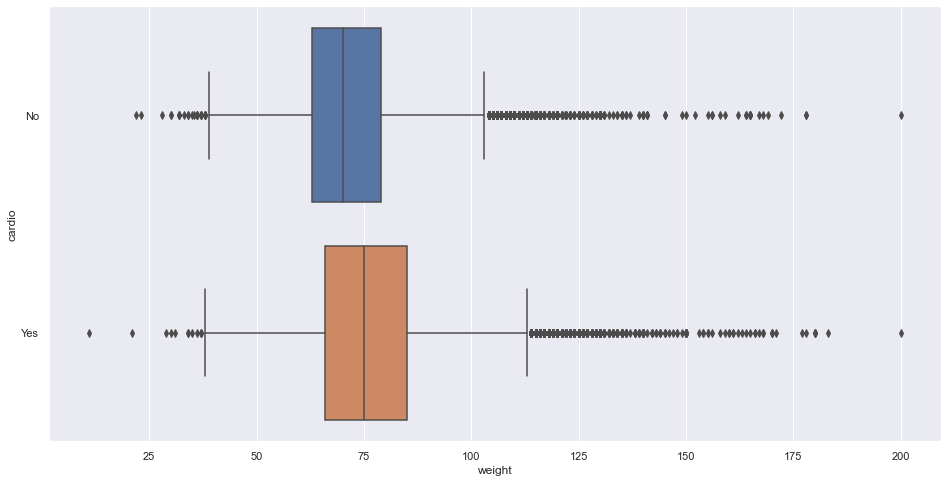

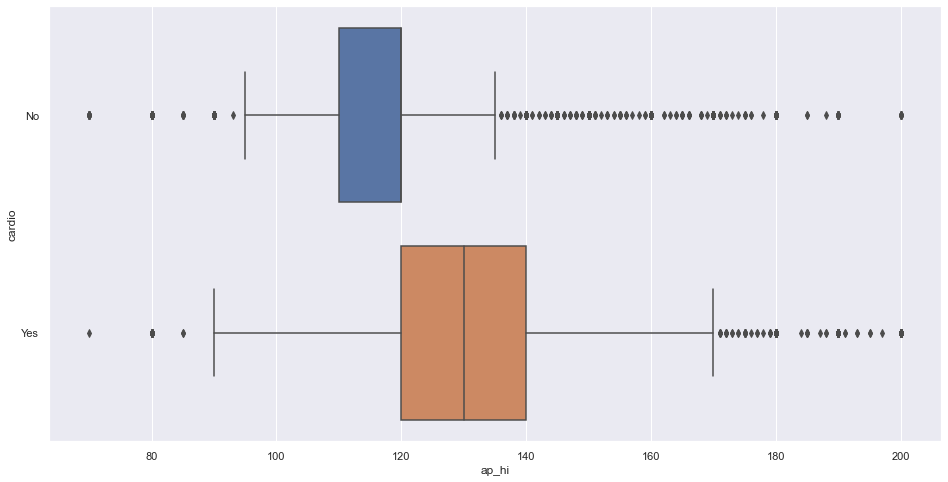

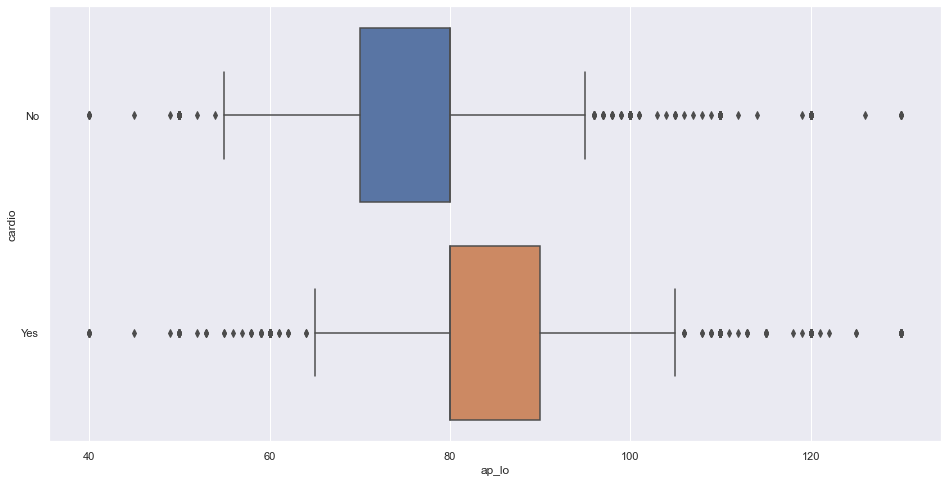

In [27]:
for var in NumData:
    f, axes = plt.subplots(1, 1, figsize=(16, 8))
    sb.boxplot(x = var, y = CatData['cardio'], data = data)

Machine Learning

In [28]:
X = learndata.iloc[:, :-1]
y = learndata.iloc[:, -1:].values

print('input size :', X.shape)
print('output size:', y.shape)
print('Missing data check:', 'No missing data' if X.isnull().sum().sum() == 0 else X.isnull().sum().sum())

input size : (68669, 12)
output size: (68669, 1)
Missing data check: No missing data


In [29]:
numerical = data.select_dtypes(include = np.number).columns.tolist()
categorical = data.select_dtypes(include = 'category').columns.tolist()

learndata

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,62,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Split data set into 75%-25% train test split for machine learning.

In [30]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print('Training dataset size:', X_train.shape)
print('Test dataset size    :', X_test.shape)

Training dataset size: (51501, 12)
Test dataset size    : (17168, 12)


Scale numerical data in order for machine learning to be more accurate. Models trained on scaled data tend to have higher performance compared to models trained on unscaled data.

In [31]:
scaler = MinMaxScaler().fit(X_train[numerical])
X_train[numerical] = scaler.transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

Show the accuracy of DecisionTreeClassifer and AdaBoostClassifier

In [32]:
classifiers = [DecisionTreeClassifier(random_state = 41), AdaBoostClassifier(random_state = 41),]
def train_model(classifier):
  model = classifier.fit(X_train, y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  test_accuracy = round(accuracy_score(y_test, test_pred), 4)
  loss = round(zero_one_loss(y_test, test_pred), 4)
  f1 = round(f1_score(y_test, test_pred, average = 'binary'), 4)

  return str(classifier), test_accuracy, loss, f1
  
base = pd.DataFrame([train_model(classifier) for classifier in classifiers], 
                       columns = ['Model', 'Test Accuracy', 'Zero-One Loss', 'F1 Score'])
base

,Model,Test Accuracy,Zero-One Loss,F1 Score
0,DecisionTreeClassifier(random_state=41),0.6331,0.3669,0.6314
1,AdaBoostClassifier(random_state=41),0.7292,0.2708,0.7064


At first glance, AdaBoost seems to outperform DecisionTree significantly.

Now we optimise the machine learning to see if we get a change in accuracy.

The following function is used for calculating and printing the results 
 after training each model with the best hyperparameters chosen.

In [33]:
results = pd.DataFrame(columns = ['Model', 'Test Accuracy', 'Zero-One Loss', 'F1 Score'])

def print_and_append(model, y_test, test_pred):
  test_accuracy = round(accuracy_score(y_test, test_pred), 4)
  loss = round(zero_one_loss(y_test, test_pred), 4)
  f1 = round(f1_score(y_test, test_pred), 4)

  print('Test accuracy:', test_accuracy)
  print('Zero-One Loss:', loss)
  print('F1 Score:', f1)
  
  global results
  results = results.append({
    'Model': model,
    'Test Accuracy': test_accuracy,
    'Zero-One Loss': loss,
    'F1 Score': f1}, ignore_index = True)

def cr_and_cm(model, y_test, test_pred):
  print('\nClassification Report and Confusion Matrix')
  print('------------------------------------------')
  print(classification_report(y_test, test_pred))
  
  cm = confusion_matrix(y_test, test_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
  disp.plot()
  plt.show();

Decision Tree

In [34]:
def tune_decision_tree(target_feature_value, **params):
  dt_model = DecisionTreeClassifier(**params).fit(X_train, y_train)
  train_pred = dt_model.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)

  test_pred = dt_model.predict(X_test)
  test_accuracy = accuracy_score(y_test, test_pred)

  return target_feature_value, train_accuracy, test_accuracy

# Plotting the accuracy of the model for different values of a feature
def plot_model(feature):
  plt.figure(figsize = (8, 5))
  plt.plot(df[feature], df['Training Accuracy'], label = 'Training Accuracy')
  plt.plot(df[feature], df['Test Accuracy'], label = 'Test Accuracy')
  
  plt.xlabel(feature)
  plt.ylabel('Accuracy')
  plt.legend();

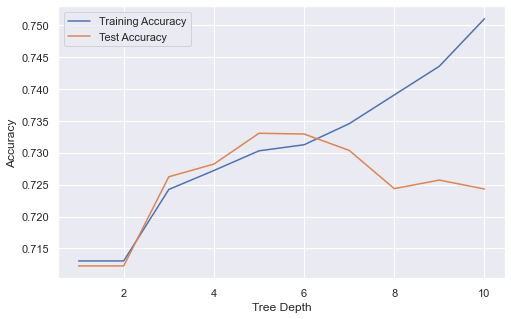

In [35]:
df = pd.DataFrame([tune_decision_tree(target_feature_value = i, 
                                      criterion = 'gini', 
                                      splitter  = 'best', 
                                      random_state = 41, 
                                      max_depth = i) for i in range(1, 11)],
                  columns = ['Tree Depth', 'Training Accuracy', 'Test Accuracy'])

plot_model('Tree Depth')

Here we see that our test accuracy is highest at a tree depth of 5, so we will optimise our DecisionTreeClassifier with a tree depth of 5.

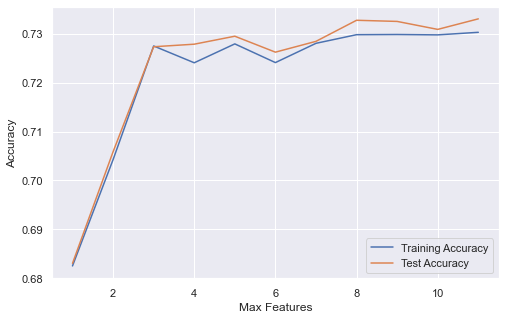

In [36]:
df = pd.DataFrame([tune_decision_tree(target_feature_value = i, 
                                      criterion = 'gini', 
                                      splitter  = 'best',
                                      max_depth = 5,
                                      max_features = i,
                                      random_state = 41) for i in range(1, 12)],
    columns = ['Max Features', 'Training Accuracy', 'Test Accuracy'])

plot_model('Max Features')

Accuracy is highest when max features is 11

Hence our final DecisionTreeClasifier model will use a max depth of 5 and a max number of features of 11


Test accuracy: 0.733
Zero-One Loss: 0.267
F1 Score: 0.7022

Classification Report and Confusion Matrix
------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      8660
           1       0.79      0.64      0.70      8508

    accuracy                           0.73     17168
   macro avg       0.74      0.73      0.73     17168
weighted avg       0.74      0.73      0.73     17168



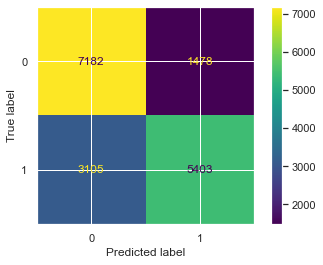

In [37]:
final_dt_model = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 5, max_features = 11, random_state = 41).fit(X_train, y_train)
test_pred = final_dt_model.predict(X_test)

print_and_append('DecisionTree', y_test, test_pred)
cr_and_cm(final_dt_model, y_test, test_pred)

In [38]:
base.iloc[:1, :]

,Model,Test Accuracy,Zero-One Loss,F1 Score
0,DecisionTreeClassifier(random_state=41),0.6331,0.3669,0.6314


Adaboost

In [39]:
def tune_adaboost(target_feature_value, **params):
  boost_model = AdaBoostClassifier(**params).fit(X_train, y_train)
  train_pred = boost_model.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)

  test_pred = boost_model.predict(X_test)
  test_accuracy = accuracy_score(y_test, test_pred)

  return target_feature_value, train_accuracy, test_accuracy

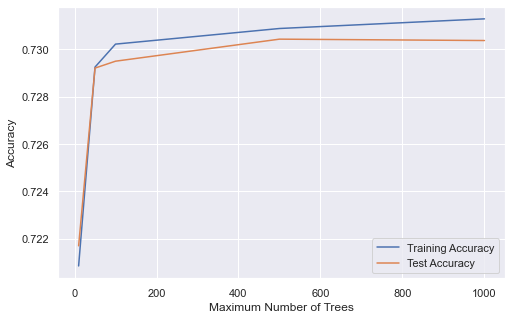

In [40]:
trees = [10, 50, 100, 500, 1000]
df = pd.DataFrame([tune_adaboost(target_feature_value = i,
                                 base_estimator = None,
                                 n_estimators = i,
                                 random_state = 41) for i in trees], 
                  columns = ['Maximum Number of Trees', 'Training Accuracy', 'Test Accuracy'])

plot_model('Maximum Number of Trees')

Accuracy is highest at 500 trees

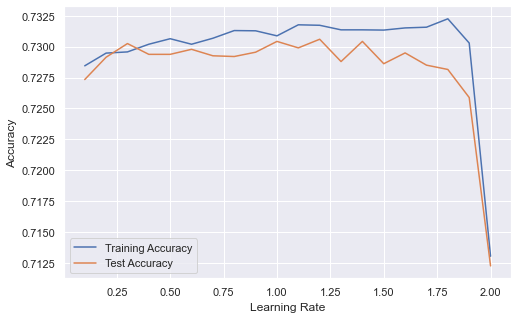

In [41]:
df = pd.DataFrame([tune_adaboost(target_feature_value = i,
                                 base_estimator = None,
                                 n_estimators = 500,
                                 learning_rate = i,
                                 random_state = 41) for i in np.arange(0.1, 2.1, 0.1)], 
                  columns = ['Learning Rate', 'Training Accuracy', 'Test Accuracy'])

plot_model('Learning Rate')

Accuracy is highest at learning rate of 1.21

 Hence our AdaBoostClassifier will use the conditions of 500 number of trees and a learning rate of 1.21

Test accuracy: 0.7307
Zero-One Loss: 0.2693
F1 Score: 0.707

Classification Report and Confusion Matrix
------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      8660
           1       0.77      0.66      0.71      8508

    accuracy                           0.73     17168
   macro avg       0.74      0.73      0.73     17168
weighted avg       0.74      0.73      0.73     17168



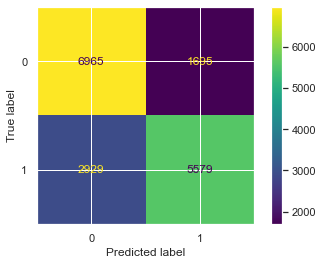

In [42]:
final_boost_model = AdaBoostClassifier(base_estimator = None, n_estimators = 500, learning_rate = 1.21, random_state = 42)
final_boost_model.fit(X_train, y_train)
test_pred = final_boost_model.predict(X_test)

print_and_append('AdaBoost', y_test, test_pred)
cr_and_cm(final_boost_model, y_test, test_pred)

In [43]:
base.iloc[1:2, :]

,Model,Test Accuracy,Zero-One Loss,F1 Score
1,AdaBoostClassifier(random_state=41),0.7292,0.2708,0.7064


In [44]:
base

,Model,Test Accuracy,Zero-One Loss,F1 Score
0,DecisionTreeClassifier(random_state=41),0.6331,0.3669,0.6314
1,AdaBoostClassifier(random_state=41),0.7292,0.2708,0.7064


In [45]:
results

,Model,Test Accuracy,Zero-One Loss,F1 Score
0,DecisionTree,0.733,0.267,0.7022
1,AdaBoost,0.7307,0.2693,0.707


Accuracy of DecisionTree has improved massively from 0.6331 to 0.733

Accuracy of AdaBoost increase slightly from 0.7292 to 0.7307

K Neighbors

In [46]:
knn_scores = []
for k in range(1, 41):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    knn_classifier.fit(X_train,y_train)
    knn_scores.append(knn_classifier.score(X_test, y_test).round(3))

Text(0.5, 1.0, 'K Neighbors Classifier scores for different K values')

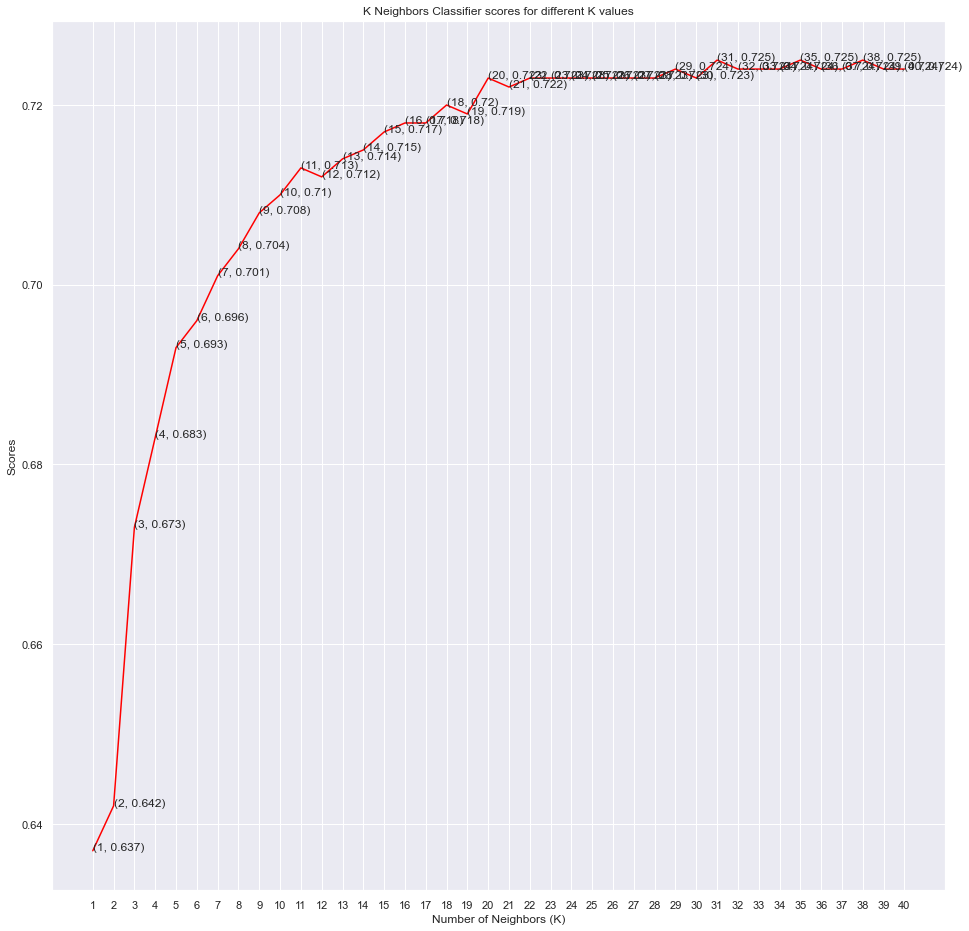

In [47]:
plt.figure(figsize=(16,16))
plt.plot([k for k in range(1, 41)], knn_scores, color = 'red')
for i in range(1,41):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1, 41)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

In [48]:
print('Average Accuracy: %.3f (%.3f)' % (mean(knn_scores), std(knn_scores)))

Average Accuracy: 0.712 (0.020)


The highest accuracy is when K = 31/35/38 neighbors at 0.725

Random Forest

In [49]:
rf_scores = []
estimators = [10, 100, 200, 500, 1000]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 41)
    train_model(rf_classifier)
    rf_scores.append(rf_classifier.score(X_test, y_test).round(3))

Text(0.5, 1.0, 'Random Forest Classifier scores for different number of estimators')

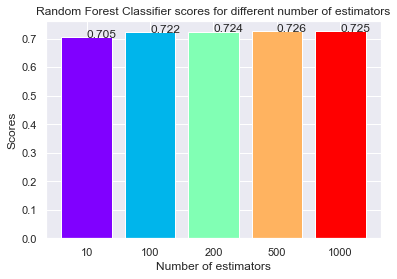

In [50]:
colors = rainbow(np.linspace(0, 1, len(estimators)))
plt.bar([i for i in range(len(estimators))], rf_scores, color = colors, width = 0.8)
for i in range(len(estimators)):
    plt.text(i, rf_scores[i], rf_scores[i])
plt.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different number of estimators')

In [51]:
print('Average Accuracy: %.3f (%.3f)' % (mean(rf_scores), std(rf_scores)))

Average Accuracy: 0.720 (0.008)


Highest Accuracy is when number of estimators is at 500, at 0.726